This notebook implements the Quantum Random Walk on an Integer number line, it uses the IBM's
quantum computing SDK Qiskit to implement the algorithm, there are two methods implemnted below to perform a quantum walk step - 1) Using an operator that is later converted to gate and 2) with direct use of standard gates provided by qiskit. 


In [7]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import plot_histogram
import numpy as np

In [4]:
# Define a routine to create and returns a control gate from standard qiskit gates to increment or
# decrement input by value of  1 
def add_sub_gate(flag, no_qubits) :
    qc = QuantumCircuit(no_qubits)
    cx_qubits = no_qubits - 1
    if flag == 1 : # if flag = 1, we need gates which will add 1 to input 
        for n in range(cx_qubits) : 
            qc.mcx(list(range(0, cx_qubits - n)), cx_qubits - n)
    else : # when flag is not 1, we need to perform a substraction by 1 
        for n in range(cx_qubits) : 
            qc.x(range(0, cx_qubits - n)) # set control to act by 0 state
            qc.mcx(list(range(0, cx_qubits - n)), cx_qubits - n)
            qc.x(range(0, cx_qubits - n)) # revert control to original state
    qc.x(0)
    return qc.to_gate().control()  # return a control gate for increment or decrement

In [5]:
# Quantum Random Walk Implemented using qiskit gates
num_qubits =  7  # set an integer range (2**num_qubits) by chosing a number of qubits 
num_clbits = 7   # classcial register set to read output value at time of measurement
steps = 10       # set number of steps 

qcr = QuantumRegister(num_qubits + 1)
cr = ClassicalRegister(num_clbits)

qc_RWalk_gates = QuantumCircuit(qcr, cr)  # define quantum circuit with gates

# set the initial value of control qubit as |+i> state
qc_RWalk_gates.h(0)
qc_RWalk_gates.rz(np.pi/2, 0)

# set the input value as a mid point on integer line from where the random moves will start
qc_RWalk_gates.x(range(1, num_qubits))  

Decr_gate = add_sub_gate(0, num_qubits)
Incr_gate = add_sub_gate(1, num_qubits)

# perform quantum walk for defined steps
for _ in range(steps) :
    qc_RWalk_gates.h(0)
    qc_RWalk_gates.append(Incr_gate, range(0, num_qubits+1))
    qc_RWalk_gates.x(0)
    qc_RWalk_gates.append(Decr_gate, range(0, num_qubits+1))
    qc_RWalk_gates.x(0)

qc_RWalk_gates.measure(range(1, num_qubits+1), range(0, num_clbits))

#qc_RWalk_gates.draw()


Execution time for Gate circuit -   17.41


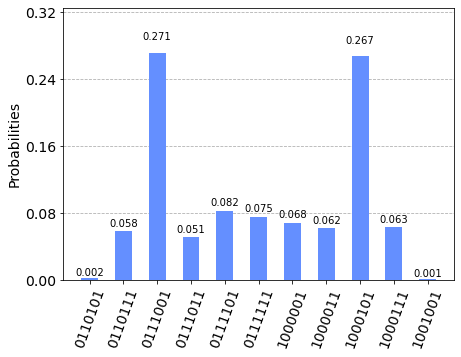

In [8]:
import timeit
start_time = timeit.default_timer()
bkend = Aer.get_backend('qasm_simulator')
job = execute(qc_RWalk_gates, backend=bkend, shots=1000)
elapsed = float("%.2f" %(timeit.default_timer() - start_time))
print('Execution time for Gate circuit -  ', elapsed)
cnt = job.result().get_counts()
plot_histogram(cnt)

Below I have implemented an alternate method to obtain control opertions using matrix operators built to increase/decrease input by rotational vector transformations. It appears that a  standard processes to convert unitary matrix to custom gates and build-in gates (supported by  h/w) is generatig a very large sequence one and two qubit gates which eventually lead to lot more time and consumption of resources hence it may not very useful to run with real hardware.

Despite it may be a good option to implement such matrix based transformation on a simulation platform that is equipped to do efficient/faster calculation on unitary/sparse matrices, I will share a similar implementaion using qutip to further study this concept.


In [18]:
# Define a subroutine to create and returns a control gate  to increment or decrement input 
# by value of  1 this time using a unitary matrix opertor 
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
def Incr_Decr_Oper(flag, no_qubits) :
    dim=2**no_qubits
    if flag == 0:   #  it is a decrement by 1
        matrix = np.diag(np.ones(dim-1),1)
        matrix[dim-1, 0] = 1
    else : # it is a increment by 1
        matrix = np.diag(np.ones(dim-1),-1)
        matrix[0, dim-1] = 1
    gate_op = Operator(matrix)
    gate = UnitaryGate(gate_op,'Unit_Gate')
    return gate.control()

In [19]:
# Quantum Random Walk Implemented using gates obtained from increase decrease operators 
num_qubits =  5  # set an integer range by chosing number of qubits
num_clbits = 5   # classcial register set to read output value at measurement
steps = 8        # set number of steps 

qcr = QuantumRegister(num_qubits + 1)
cr = ClassicalRegister(num_clbits)
qc_RWalk = QuantumCircuit(qcr, cr) # define a quantum circuit 

# set the initial value of control qubit as |+i> state
qc_RWalk.h(0)
qc_RWalk.rz(np.pi/2, 0)

# set the input value as a mid point on integer line from where the random moves will start
qc_RWalk.x(range(1, num_qubits)) 

Decr_Oper = Incr_Decr_Oper(0, num_qubits)
Incr_Oper = Incr_Decr_Oper(1, num_qubits)

# perform quantum walk for defined steps
for _ in range(steps) :
    qc_RWalk.h(0)
    qc_RWalk.append(Incr_Oper, range(0, num_qubits+1))
    qc_RWalk.x(0)
    qc_RWalk.append(Decr_Oper, range(0, num_qubits+1))
    qc_RWalk.x(0)

qc_RWalk.measure(range(1, num_qubits+1), range(0, num_clbits))

#qc_RWalk.draw()


Execution time for Oper circuit -   92.88


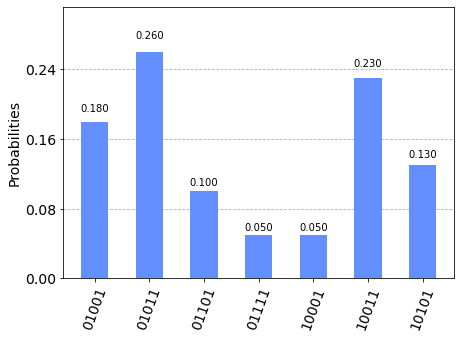

In [20]:
import timeit
start_time = timeit.default_timer()
bkend = Aer.get_backend('qasm_simulator')
job1 = execute(qc_RWalk, backend=bkend, shots=100)
elapsed = float("%.2f" %(timeit.default_timer() - start_time))
print('Execution time for Oper circuit -  ', elapsed)
cnts = job1.result().get_counts()
plot_histogram(cnts)

In [17]:
# this is how our given unitary matrix operator has been converted to a large sequence of elemntary 
# gates and this is why this method (matrix to gate) is taking a lot more time. notice that with 
# using direct gates we are running our circuit (shots) for 1000 times, number of shots is 100 and
# in second method and still it is taking good amount of time.
qc = QuantumCircuit(3)
qc.h(0)
qc.append(Incr_Decr_Oper(0,2), range(0, 3))
bkend = Aer.get_backend('qasm_simulator')
transpile(qc, bkend, optimization_level=3).draw()


global phase: 5π/8
     ┌───┐┌─────────────┐┌───┐┌──────────┐┌───┐┌─────────────┐┌───┐»
q_0: ┤ H ├┤ RZ(0.68722) ├┤ X ├┤ RZ(-π/4) ├┤ X ├┤ RZ(-1.3008) ├┤ X ├»
     └───┘└─────────────┘└─┬─┘└──────────┘└─┬─┘└─────────────┘└─┬─┘»
q_1: ──────────────────────■────────────────┼───────────────────■──»
                                            │                      »
q_2: ───────────────────────────────────────■──────────────────────»
                                                                   »
«     ┌──────────────┐┌───┐┌──────────┐  ┌─────────┐            ┌───┐     »
«q_0: ┤ RZ(-0.26998) ├┤ X ├┤ RZ(-π/2) ├──┤ RY(π/2) ├────────────┤ X ├─────»
«     ├─────────────┬┘└─┬─┘└──┬───┬───┘┌─┴─────────┴──┐┌───┐    └─┬─┘     »
«q_1: ┤ RZ(-3.4852) ├───┼─────┤ X ├────┤ RZ(-0.51542) ├┤ X ├──────■───────»
«     └─────────────┘   │     └─┬─┘    └──────────────┘└─┬─┘┌────────────┐»
«q_2: ──────────────────■───────■────────────────────────■──┤ P(-1.4707) ├»
«                                                           └────────────┘»
«     ┌──────────┐┌─────────┐┌─────────┐┌───┐┌─────────┐┌─────────┐┌──────────┐»
«q_0: ┤ RZ(-π/2) ├┤ RY(π/2) ├┤ RZ(π/2) ├┤ X ├┤ RZ(π/2) ├┤ RY(π/2) ├┤ RZ(-π/2) ├»
«     └──────────┘└─────────┘└─────────┘└─┬─┘└─────────┘└─────────┘└──────────┘»
«q_1: ────────────────────────────────────┼────────────────────────────────────»
«                                         │                                    »
«q_2: ────────────────────────────────────■────────────────────────────────────»
«                                                                              »
«     ┌───┐ ┌────────┐ ┌─────────┐┌─────────┐┌─────────┐           »
«q_0: ┤ X ├─┤ RZ(-π) ├─┤ RY(π/2) ├┤ P(-π/4) ├┤ RY(π/2) ├───────────»
«     └─┬─┘┌┴────────┴┐├─────────┤└──┬───┬──┘└┬────────┤┌─────────┐»
«q_1: ──■──┤ RZ(-π/2) ├┤ RY(π/2) ├───┤ X ├────┤ RZ(-π) ├┤ RY(π/2) ├»
«          └──────────┘└─────────┘   └─┬─┘    └────────┘└─────────┘»
«q_2: ─────────────────────────────────■───────────────────────────»
«                                                                  »
«                    ┌───┐┌──────────┐┌─────────┐┌─────────┐┌───┐┌─────────┐ »
«q_0: ───────────────┤ X ├┤ RZ(-π/2) ├┤ RY(π/2) ├┤ RZ(π/2) ├┤ X ├┤ RZ(π/2) ├─»
«     ┌─────────────┐└─┬─┘└──────────┘└─────────┘└─────────┘└─┬─┘└─────────┘ »
«q_1: ┤ P(-0.44179) ├──■──────────────────────────────────────┼──────────────»
«     └─────────────┘                                         │  ┌──────────┐»
«q_2: ────────────────────────────────────────────────────────■──┤ RY(2π/3) ├»
«                                                                └──────────┘»
«       ┌─────────┐   ┌──────────┐┌───┐┌────────┐┌─────────┐┌──────────┐     »
«q_0: ──┤ RY(π/2) ├───┤ RZ(-π/2) ├┤ X ├┤ RZ(-π) ├┤ RY(π/2) ├┤ P(-7π/8) ├──■──»
«       └─────────┘   └──────────┘└─┬─┘└────────┘└─────────┘└──────────┘  │  »
«q_1: ──────────────────────────────■─────────────────────────────────────┼──»
«     ┌──────────────┐                                                  ┌─┴─┐»
«q_2: ┤ RZ(-0.61548) ├──────────────────────────────────────────────────┤ X ├»
«     └──────────────┘                                                  └───┘»
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«                                              ┌─────────┐ ┌─────────┐»
«q_1: ──────────────────────────────────────■──┤ RY(π/2) ├─┤ RZ(π/2) ├»
«     ┌─────────┐┌──────────┐┌───────────┐┌─┴─┐├─────────┴┐├─────────┤»
«q_2: ┤ RZ(π/2) ├┤ RY(3π/4) ├┤ RZ(-3π/4) ├┤ X ├┤ RZ(3π/4) ├┤ RY(π/2) ├»
«     └─────────┘└──────────┘└───────────┘└───┘└──────────┘└─────────┘»
«                      ┌─────────┐                                       »
«q_0: ──────────────■──┤ RY(π/2) ├───────────────────────────────────────»
«                   │  └─────────┘                       ┌───┐┌─────────┐»
«q_1: ──────────────┼────────────────────────────────────┤ X ├┤ RZ(π/2) ├»
«     

In [ ]:
# end of program